In [79]:
# базовые импорты для работы с данными
import pandas as pd
import matplotlib.pyplot as plt

# модель и токенайзер
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# для обучения
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# препроцессинг + метрики
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm

In [80]:
# загружаем данные

df = pd.read_csv("/data_big.tsv", sep='\t')

In [81]:
df.sample(2)

,report,label
135,Хочу поблагодарить сотрудников отделения на Ру...,благодарность
101,Выражаю благодарность Юлии Семёновне С. Кратка...,благодарность


In [82]:
print(df[pd.isnull(df["label"])])

Empty DataFrame
Columns: [report, label]
Index: []


In [83]:
# посмотреть какие лейблы вообще есть
df.label.unique()

array(['благодарность', 'претензия', 'предложение'], dtype=object)

In [84]:
# проверяем пустые данные
# видим что 91 пустой текст
# и 53 лейбла с пустыми строками в качестве текста
# это всё надо будет удалить

# с лейблами всё в порядке
print(df['report'].isnull().sum())
print(df['label'].isnull().sum())
print((df['report'].str.strip() == '').sum())
print((df['label'].str.strip() == '').sum())

0
0
0
0


In [85]:
# избавляемся от пустых значений
# предположим, что при конечном использовании модели
# пустой пользовательский ввод будет каким-либо образом запрещён/ограничен
df = df.dropna(subset=['report'])
df = df[df['report'].str.strip() != '']

In [86]:
# sanity check
print(df['report'].isnull().sum())
print((df['report'].str.strip() == '').sum())

0
0


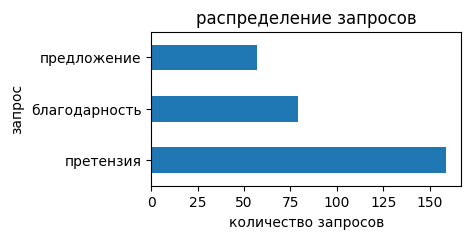

In [87]:
# проверка на всякий случай
# для понимания какие метрики потом использовать
plt.figure(figsize=(4, 2))
df['label'].value_counts().sort_values(ascending=False).plot(kind='barh')
plt.title('распределение запросов')
plt.xlabel('количество запросов')
plt.ylabel('запрос', va='center',labelpad=10)
plt.show()

In [88]:
# label encoding как один из наиболее простых вариантов
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [121]:
# сохранение энкодера
import numpy
numpy.save('/model/classes.npy', le.classes_)

In [105]:
# инициализируем модель и токенайзер
name = 'cointegrated/rubert-tiny'
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=len(df.label.unique()))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [106]:
train_df, tmp_df = train_test_split(df, test_size=0.4,stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['label'],random_state=42)

In [107]:
# кастомный датасет
class CustomDataset(Dataset):
    def __init__(self, reports, labels, tokenizer, max_len=128):
        self.reports = reports
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reports)

    def __getitem__(self, idx):
        res={}
        report = self.reports[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            report,
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,)

        res['input_ids'] = encoding['input_ids'].flatten()
        res['attention_mask'] = encoding['attention_mask'].flatten()
        res['labels']= torch.tensor(label, dtype=torch.long)

        return res

In [108]:
# делим на 3 датасета
train_dataset = CustomDataset(train_df['report'].values, train_df['label'].values, tokenizer)
val_dataset = CustomDataset(val_df['report'].values, val_df['label'].values, tokenizer)
test_dataset = CustomDataset(test_df['report'].values, test_df['label'].values, tokenizer)

In [109]:
# загружаем сплиты в dataloader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [110]:
# перекидываем на gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# определяем оптимизатор и ф-ю потерь
# Возможно нужно подкрутить lr и weight_decay
optimizer = AdamW(model.parameters(), lr=2e-6)
loss_fn = nn.CrossEntropyLoss()

In [111]:
# основная часть -- training/eval loops
epochs = 160
# Количество жпох нужно подобрать, чтобы loss падала ближе к 0, а f1_score должна быть близка к 1
train_losses = []
val_losses = []
f1_scores = []

for epoch in range(epochs):
    # обучение
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'train epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'train loss: {avg_train_loss}')

    # валидация
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'val epoch {epoch + 1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = loss_fn(logits, labels)
    val_losses.append(val_loss.item())

    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    f1_scores.append(val_f1)

    print(f'val loss: {val_loss.item()}')
    print(f'val f1-score: {val_f1}')

# тест
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


train epoch 1/160: 100%|██████████| 23/23 [00:00<00:00, 51.87it/s]


train loss: 1.0889402705690134


val epoch 1/160: 100%|██████████| 8/8 [00:00<00:00, 111.81it/s]


val loss: 1.0684632062911987
val f1-score: 0.45705660018541844


train epoch 2/160: 100%|██████████| 23/23 [00:00<00:00, 58.12it/s]


train loss: 1.082559409348861


val epoch 2/160: 100%|██████████| 8/8 [00:00<00:00, 97.48it/s]


val loss: 1.0426255464553833
val f1-score: 0.5259193180691842


train epoch 3/160: 100%|██████████| 23/23 [00:00<00:00, 55.40it/s]


train loss: 1.0723876953125


val epoch 3/160: 100%|██████████| 8/8 [00:00<00:00, 110.03it/s]


val loss: 1.0164679288864136
val f1-score: 0.5606858574075345


train epoch 4/160: 100%|██████████| 23/23 [00:00<00:00, 59.85it/s]


train loss: 1.06330799019855


val epoch 4/160: 100%|██████████| 8/8 [00:00<00:00, 92.54it/s]


val loss: 0.9932475090026855
val f1-score: 0.5831169260250437


train epoch 5/160: 100%|██████████| 23/23 [00:00<00:00, 46.10it/s]


train loss: 1.047805894976077


val epoch 5/160: 100%|██████████| 8/8 [00:00<00:00, 72.86it/s]


val loss: 0.9694111943244934
val f1-score: 0.5539206556155709


train epoch 6/160: 100%|██████████| 23/23 [00:00<00:00, 39.39it/s]


train loss: 1.0475021445232888


val epoch 6/160: 100%|██████████| 8/8 [00:00<00:00, 72.37it/s]


val loss: 0.9413254857063293
val f1-score: 0.5240539336226957


train epoch 7/160: 100%|██████████| 23/23 [00:00<00:00, 40.02it/s]


train loss: 1.0245129880697832


val epoch 7/160: 100%|██████████| 8/8 [00:00<00:00, 64.02it/s]


val loss: 0.9187896847724915
val f1-score: 0.5240539336226957


train epoch 8/160: 100%|██████████| 23/23 [00:00<00:00, 35.17it/s]


train loss: 1.0138858608577563


val epoch 8/160: 100%|██████████| 8/8 [00:00<00:00, 67.04it/s]


val loss: 0.8924921154975891
val f1-score: 0.5222425032594524


train epoch 9/160: 100%|██████████| 23/23 [00:00<00:00, 37.54it/s]


train loss: 1.002607576225115


val epoch 9/160: 100%|██████████| 8/8 [00:00<00:00, 103.28it/s]


val loss: 0.8628703951835632
val f1-score: 0.4695730988851627


train epoch 10/160: 100%|██████████| 23/23 [00:00<00:00, 53.15it/s]


train loss: 0.9914544457974641


val epoch 10/160: 100%|██████████| 8/8 [00:00<00:00, 103.03it/s]


val loss: 0.8339443802833557
val f1-score: 0.4426675676182968


train epoch 11/160: 100%|██████████| 23/23 [00:00<00:00, 56.89it/s]


train loss: 0.9877098047215006


val epoch 11/160: 100%|██████████| 8/8 [00:00<00:00, 103.21it/s]


val loss: 0.8068454265594482
val f1-score: 0.4763237419524372


train epoch 12/160: 100%|██████████| 23/23 [00:00<00:00, 52.18it/s]


train loss: 0.9643019852430924


val epoch 12/160: 100%|██████████| 8/8 [00:00<00:00, 88.90it/s]


val loss: 0.7806122899055481
val f1-score: 0.4763237419524372


train epoch 13/160: 100%|██████████| 23/23 [00:00<00:00, 55.18it/s]


train loss: 0.972494055395541


val epoch 13/160: 100%|██████████| 8/8 [00:00<00:00, 106.91it/s]


val loss: 0.7530691027641296
val f1-score: 0.4763237419524372


train epoch 14/160: 100%|██████████| 23/23 [00:00<00:00, 56.48it/s]


train loss: 0.947103650673576


val epoch 14/160: 100%|██████████| 8/8 [00:00<00:00, 100.17it/s]


val loss: 0.7305989861488342
val f1-score: 0.5054712521882615


train epoch 15/160: 100%|██████████| 23/23 [00:00<00:00, 56.34it/s]


train loss: 0.9286098480224609


val epoch 15/160: 100%|██████████| 8/8 [00:00<00:00, 106.48it/s]


val loss: 0.7037474513053894
val f1-score: 0.5054712521882615


train epoch 16/160: 100%|██████████| 23/23 [00:00<00:00, 54.77it/s]


train loss: 0.9243817277576613


val epoch 16/160: 100%|██████████| 8/8 [00:00<00:00, 107.19it/s]


val loss: 0.68159419298172
val f1-score: 0.5609983237101882


train epoch 17/160: 100%|██████████| 23/23 [00:00<00:00, 55.35it/s]


train loss: 0.9340502619743347


val epoch 17/160: 100%|██████████| 8/8 [00:00<00:00, 103.27it/s]


val loss: 0.6577763557434082
val f1-score: 0.5609983237101882


train epoch 18/160: 100%|██████████| 23/23 [00:00<00:00, 55.74it/s]


train loss: 0.9276168242744778


val epoch 18/160: 100%|██████████| 8/8 [00:00<00:00, 103.32it/s]


val loss: 0.6385290026664734
val f1-score: 0.5609983237101882


train epoch 19/160: 100%|██████████| 23/23 [00:00<00:00, 55.54it/s]


train loss: 0.8927163170731586


val epoch 19/160: 100%|██████████| 8/8 [00:00<00:00, 108.65it/s]


val loss: 0.6221299767494202
val f1-score: 0.5857789341554911


train epoch 20/160: 100%|██████████| 23/23 [00:00<00:00, 53.74it/s]


train loss: 0.8796931012817051


val epoch 20/160: 100%|██████████| 8/8 [00:00<00:00, 102.41it/s]


val loss: 0.6023679375648499
val f1-score: 0.6132565243768221


train epoch 21/160: 100%|██████████| 23/23 [00:00<00:00, 56.81it/s]


train loss: 0.8653810827628426


val epoch 21/160: 100%|██████████| 8/8 [00:00<00:00, 112.49it/s]


val loss: 0.5799839496612549
val f1-score: 0.6132565243768221


train epoch 22/160: 100%|██████████| 23/23 [00:00<00:00, 54.38it/s]


train loss: 0.8888467239296954


val epoch 22/160: 100%|██████████| 8/8 [00:00<00:00, 101.58it/s]


val loss: 0.5615532994270325
val f1-score: 0.6132565243768221


train epoch 23/160: 100%|██████████| 23/23 [00:00<00:00, 56.61it/s]


train loss: 0.8710305146549059


val epoch 23/160: 100%|██████████| 8/8 [00:00<00:00, 112.60it/s]


val loss: 0.5510303378105164
val f1-score: 0.6129599087103386


train epoch 24/160: 100%|██████████| 23/23 [00:00<00:00, 53.62it/s]


train loss: 0.8641139683516129


val epoch 24/160: 100%|██████████| 8/8 [00:00<00:00, 106.07it/s]


val loss: 0.5408307909965515
val f1-score: 0.6600923015214125


train epoch 25/160: 100%|██████████| 23/23 [00:00<00:00, 55.96it/s]


train loss: 0.8516816393188809


val epoch 25/160: 100%|██████████| 8/8 [00:00<00:00, 104.80it/s]


val loss: 0.528590738773346
val f1-score: 0.6806292382606917


train epoch 26/160: 100%|██████████| 23/23 [00:00<00:00, 55.50it/s]


train loss: 0.8741673982661703


val epoch 26/160: 100%|██████████| 8/8 [00:00<00:00, 104.64it/s]


val loss: 0.5159042477607727
val f1-score: 0.6996323908630468


train epoch 27/160: 100%|██████████| 23/23 [00:00<00:00, 54.83it/s]


train loss: 0.8373744669167892


val epoch 27/160: 100%|██████████| 8/8 [00:00<00:00, 107.35it/s]


val loss: 0.5068881511688232
val f1-score: 0.6996323908630468


train epoch 28/160: 100%|██████████| 23/23 [00:00<00:00, 52.07it/s]


train loss: 0.807496550290481


val epoch 28/160: 100%|██████████| 8/8 [00:00<00:00, 76.44it/s]


val loss: 0.49562832713127136
val f1-score: 0.6996323908630468


train epoch 29/160: 100%|██████████| 23/23 [00:00<00:00, 34.50it/s]


train loss: 0.7970719972382421


val epoch 29/160: 100%|██████████| 8/8 [00:00<00:00, 62.08it/s]


val loss: 0.4839784801006317
val f1-score: 0.6996323908630468


train epoch 30/160: 100%|██████████| 23/23 [00:00<00:00, 37.39it/s]


train loss: 0.7897717771322831


val epoch 30/160: 100%|██████████| 8/8 [00:00<00:00, 58.82it/s]


val loss: 0.4708133637905121
val f1-score: 0.740953341348951


train epoch 31/160: 100%|██████████| 23/23 [00:00<00:00, 35.31it/s]


train loss: 0.7976524881694628


val epoch 31/160: 100%|██████████| 8/8 [00:00<00:00, 65.99it/s]


val loss: 0.45470520853996277
val f1-score: 0.740953341348951


train epoch 32/160: 100%|██████████| 23/23 [00:00<00:00, 36.51it/s]


train loss: 0.7745724488859591


val epoch 32/160: 100%|██████████| 8/8 [00:00<00:00, 105.98it/s]


val loss: 0.4486824572086334
val f1-score: 0.740953341348951


train epoch 33/160: 100%|██████████| 23/23 [00:00<00:00, 55.56it/s]


train loss: 0.7969565702521283


val epoch 33/160: 100%|██████████| 8/8 [00:00<00:00, 90.31it/s]


val loss: 0.43894919753074646
val f1-score: 0.7576467698354212


train epoch 34/160: 100%|██████████| 23/23 [00:00<00:00, 57.71it/s]


train loss: 0.7600973131863967


val epoch 34/160: 100%|██████████| 8/8 [00:00<00:00, 104.02it/s]


val loss: 0.43805256485939026
val f1-score: 0.7576467698354212


train epoch 35/160: 100%|██████████| 23/23 [00:00<00:00, 52.84it/s]


train loss: 0.766620908094489


val epoch 35/160: 100%|██████████| 8/8 [00:00<00:00, 97.91it/s]


val loss: 0.426348477602005
val f1-score: 0.7560877540538558


train epoch 36/160: 100%|██████████| 23/23 [00:00<00:00, 57.55it/s]


train loss: 0.756140947341919


val epoch 36/160: 100%|██████████| 8/8 [00:00<00:00, 110.77it/s]


val loss: 0.4182368516921997
val f1-score: 0.7792968249858448


train epoch 37/160: 100%|██████████| 23/23 [00:00<00:00, 52.03it/s]


train loss: 0.7301107541374539


val epoch 37/160: 100%|██████████| 8/8 [00:00<00:00, 98.32it/s]


val loss: 0.41028153896331787
val f1-score: 0.7792968249858448


train epoch 38/160: 100%|██████████| 23/23 [00:00<00:00, 57.72it/s]


train loss: 0.7239243776901908


val epoch 38/160: 100%|██████████| 8/8 [00:00<00:00, 107.37it/s]


val loss: 0.4013036787509918
val f1-score: 0.7792968249858448


train epoch 39/160: 100%|██████████| 23/23 [00:00<00:00, 53.59it/s]


train loss: 0.7221861067025558


val epoch 39/160: 100%|██████████| 8/8 [00:00<00:00, 99.70it/s]


val loss: 0.3931272029876709
val f1-score: 0.7792968249858448


train epoch 40/160: 100%|██████████| 23/23 [00:00<00:00, 57.21it/s]


train loss: 0.7068576683168826


val epoch 40/160: 100%|██████████| 8/8 [00:00<00:00, 104.65it/s]


val loss: 0.38708338141441345
val f1-score: 0.7792968249858448


train epoch 41/160: 100%|██████████| 23/23 [00:00<00:00, 51.40it/s]


train loss: 0.7108849261118018


val epoch 41/160: 100%|██████████| 8/8 [00:00<00:00, 98.04it/s]


val loss: 0.3804738223552704
val f1-score: 0.7792968249858448


train epoch 42/160: 100%|██████████| 23/23 [00:00<00:00, 55.48it/s]


train loss: 0.699439700530923


val epoch 42/160: 100%|██████████| 8/8 [00:00<00:00, 100.65it/s]


val loss: 0.37722912430763245
val f1-score: 0.8012427167291342


train epoch 43/160: 100%|██████████| 23/23 [00:00<00:00, 51.00it/s]


train loss: 0.6790979854438616


val epoch 43/160: 100%|██████████| 8/8 [00:00<00:00, 102.59it/s]


val loss: 0.36996105313301086
val f1-score: 0.8012427167291342


train epoch 44/160: 100%|██████████| 23/23 [00:00<00:00, 56.84it/s]


train loss: 0.6989445466062297


val epoch 44/160: 100%|██████████| 8/8 [00:00<00:00, 105.66it/s]


val loss: 0.3646133840084076
val f1-score: 0.8012427167291342


train epoch 45/160: 100%|██████████| 23/23 [00:00<00:00, 51.09it/s]


train loss: 0.6631068418855253


val epoch 45/160: 100%|██████████| 8/8 [00:00<00:00, 103.77it/s]


val loss: 0.36677590012550354
val f1-score: 0.8012427167291342


train epoch 46/160: 100%|██████████| 23/23 [00:00<00:00, 55.77it/s]


train loss: 0.6631930159485858


val epoch 46/160: 100%|██████████| 8/8 [00:00<00:00, 103.60it/s]


val loss: 0.3580682575702667
val f1-score: 0.8012427167291342


train epoch 47/160: 100%|██████████| 23/23 [00:00<00:00, 52.46it/s]


train loss: 0.6485684682493624


val epoch 47/160: 100%|██████████| 8/8 [00:00<00:00, 99.86it/s]


val loss: 0.35115742683410645
val f1-score: 0.8012427167291342


train epoch 48/160: 100%|██████████| 23/23 [00:00<00:00, 56.15it/s]


train loss: 0.6290993042614149


val epoch 48/160: 100%|██████████| 8/8 [00:00<00:00, 94.69it/s]


val loss: 0.34502673149108887
val f1-score: 0.8012427167291342


train epoch 49/160: 100%|██████████| 23/23 [00:00<00:00, 51.52it/s]


train loss: 0.6262452161830404


val epoch 49/160: 100%|██████████| 8/8 [00:00<00:00, 107.85it/s]


val loss: 0.34064173698425293
val f1-score: 0.8012427167291342


train epoch 50/160: 100%|██████████| 23/23 [00:00<00:00, 56.26it/s]


train loss: 0.6285807334858439


val epoch 50/160: 100%|██████████| 8/8 [00:00<00:00, 93.48it/s]


val loss: 0.333783358335495
val f1-score: 0.8012427167291342


train epoch 51/160: 100%|██████████| 23/23 [00:00<00:00, 48.65it/s]


train loss: 0.6118920821210613


val epoch 51/160: 100%|██████████| 8/8 [00:00<00:00, 64.48it/s]


val loss: 0.3225078284740448
val f1-score: 0.8012427167291342


train epoch 52/160: 100%|██████████| 23/23 [00:00<00:00, 38.60it/s]


train loss: 0.6107974013556605


val epoch 52/160: 100%|██████████| 8/8 [00:00<00:00, 69.56it/s]


val loss: 0.3208037316799164
val f1-score: 0.8012427167291342


train epoch 53/160: 100%|██████████| 23/23 [00:00<00:00, 38.96it/s]


train loss: 0.5946374704008517


val epoch 53/160: 100%|██████████| 8/8 [00:00<00:00, 59.37it/s]


val loss: 0.31200647354125977
val f1-score: 0.8012427167291342


train epoch 54/160: 100%|██████████| 23/23 [00:00<00:00, 36.45it/s]


train loss: 0.5920541714067045


val epoch 54/160: 100%|██████████| 8/8 [00:00<00:00, 67.56it/s]


val loss: 0.3103388547897339
val f1-score: 0.8012427167291342


train epoch 55/160: 100%|██████████| 23/23 [00:00<00:00, 36.24it/s]


train loss: 0.585663563531378


val epoch 55/160: 100%|██████████| 8/8 [00:00<00:00, 106.45it/s]


val loss: 0.30429062247276306
val f1-score: 0.8012427167291342


train epoch 56/160: 100%|██████████| 23/23 [00:00<00:00, 56.11it/s]


train loss: 0.5601125372492749


val epoch 56/160: 100%|██████████| 8/8 [00:00<00:00, 92.87it/s]


val loss: 0.29943549633026123
val f1-score: 0.8012427167291342


train epoch 57/160: 100%|██████████| 23/23 [00:00<00:00, 55.40it/s]


train loss: 0.5609239611936652


val epoch 57/160: 100%|██████████| 8/8 [00:00<00:00, 103.87it/s]


val loss: 0.29286816716194153
val f1-score: 0.8012427167291342


train epoch 58/160: 100%|██████████| 23/23 [00:00<00:00, 55.30it/s]


train loss: 0.5576509833335876


val epoch 58/160: 100%|██████████| 8/8 [00:00<00:00, 104.54it/s]


val loss: 0.2869589328765869
val f1-score: 0.8012427167291342


train epoch 59/160: 100%|██████████| 23/23 [00:00<00:00, 55.61it/s]


train loss: 0.5426463128431983


val epoch 59/160: 100%|██████████| 8/8 [00:00<00:00, 107.45it/s]


val loss: 0.2852915823459625
val f1-score: 0.8012427167291342


train epoch 60/160: 100%|██████████| 23/23 [00:00<00:00, 52.61it/s]


train loss: 0.5428473729154338


val epoch 60/160: 100%|██████████| 8/8 [00:00<00:00, 108.83it/s]


val loss: 0.2803581655025482
val f1-score: 0.8012427167291342


train epoch 61/160: 100%|██████████| 23/23 [00:00<00:00, 55.26it/s]


train loss: 0.5425905507543812


val epoch 61/160: 100%|██████████| 8/8 [00:00<00:00, 108.01it/s]


val loss: 0.2804383635520935
val f1-score: 0.8012427167291342


train epoch 62/160: 100%|██████████| 23/23 [00:00<00:00, 52.94it/s]


train loss: 0.5447847208251124


val epoch 62/160: 100%|██████████| 8/8 [00:00<00:00, 93.48it/s]


val loss: 0.2792106568813324
val f1-score: 0.8012427167291342


train epoch 63/160: 100%|██████████| 23/23 [00:00<00:00, 56.08it/s]


train loss: 0.5340246260166168


val epoch 63/160: 100%|██████████| 8/8 [00:00<00:00, 102.20it/s]


val loss: 0.27338266372680664
val f1-score: 0.8012427167291342


train epoch 64/160: 100%|██████████| 23/23 [00:00<00:00, 54.39it/s]


train loss: 0.5024327998575957


val epoch 64/160: 100%|██████████| 8/8 [00:00<00:00, 97.20it/s]


val loss: 0.2623467743396759
val f1-score: 0.8012427167291342


train epoch 65/160: 100%|██████████| 23/23 [00:00<00:00, 58.78it/s]


train loss: 0.5023724715346876


val epoch 65/160: 100%|██████████| 8/8 [00:00<00:00, 107.17it/s]


val loss: 0.26049041748046875
val f1-score: 0.8012427167291342


train epoch 66/160: 100%|██████████| 23/23 [00:00<00:00, 54.78it/s]


train loss: 0.494918220716974


val epoch 66/160: 100%|██████████| 8/8 [00:00<00:00, 91.69it/s]


val loss: 0.2573544979095459
val f1-score: 0.8012427167291342


train epoch 67/160: 100%|██████████| 23/23 [00:00<00:00, 53.96it/s]


train loss: 0.48493790237799933


val epoch 67/160: 100%|██████████| 8/8 [00:00<00:00, 108.04it/s]


val loss: 0.25044044852256775
val f1-score: 0.8020013930810308


train epoch 68/160: 100%|██████████| 23/23 [00:00<00:00, 53.20it/s]


train loss: 0.47640036305655603


val epoch 68/160: 100%|██████████| 8/8 [00:00<00:00, 88.71it/s]


val loss: 0.24424676597118378
val f1-score: 0.8012427167291342


train epoch 69/160: 100%|██████████| 23/23 [00:00<00:00, 56.20it/s]


train loss: 0.4782749556976816


val epoch 69/160: 100%|██████████| 8/8 [00:00<00:00, 105.55it/s]


val loss: 0.24044521152973175
val f1-score: 0.8020013930810308


train epoch 70/160: 100%|██████████| 23/23 [00:00<00:00, 53.22it/s]


train loss: 0.46379742933356244


val epoch 70/160: 100%|██████████| 8/8 [00:00<00:00, 84.22it/s]


val loss: 0.23591893911361694
val f1-score: 0.8020013930810308


train epoch 71/160: 100%|██████████| 23/23 [00:00<00:00, 56.16it/s]


train loss: 0.45580401109612506


val epoch 71/160: 100%|██████████| 8/8 [00:00<00:00, 105.65it/s]


val loss: 0.23773610591888428
val f1-score: 0.8020013930810308


train epoch 72/160: 100%|██████████| 23/23 [00:00<00:00, 52.31it/s]


train loss: 0.4451602878777877


val epoch 72/160: 100%|██████████| 8/8 [00:00<00:00, 88.77it/s]


val loss: 0.22445321083068848
val f1-score: 0.8020013930810308


train epoch 73/160: 100%|██████████| 23/23 [00:00<00:00, 56.91it/s]


train loss: 0.43669421128604724


val epoch 73/160: 100%|██████████| 8/8 [00:00<00:00, 104.46it/s]


val loss: 0.21869820356369019
val f1-score: 0.8020013930810308


train epoch 74/160: 100%|██████████| 23/23 [00:00<00:00, 54.39it/s]


train loss: 0.4423402923604716


val epoch 74/160: 100%|██████████| 8/8 [00:00<00:00, 94.20it/s]


val loss: 0.2187678962945938
val f1-score: 0.8020013930810308


train epoch 75/160: 100%|██████████| 23/23 [00:00<00:00, 36.84it/s]


train loss: 0.43335069910339685


val epoch 75/160: 100%|██████████| 8/8 [00:00<00:00, 72.63it/s]


val loss: 0.21553219854831696
val f1-score: 0.8020013930810308


train epoch 76/160: 100%|██████████| 23/23 [00:00<00:00, 38.71it/s]


train loss: 0.43434136717215827


val epoch 76/160: 100%|██████████| 8/8 [00:00<00:00, 64.30it/s]


val loss: 0.20794427394866943
val f1-score: 0.8020013930810308


train epoch 77/160: 100%|██████████| 23/23 [00:00<00:00, 34.56it/s]


train loss: 0.4539776962736379


val epoch 77/160: 100%|██████████| 8/8 [00:00<00:00, 61.98it/s]


val loss: 0.21056419610977173
val f1-score: 0.8225843836013328


train epoch 78/160: 100%|██████████| 23/23 [00:00<00:00, 34.95it/s]


train loss: 0.4102345491233079


val epoch 78/160: 100%|██████████| 8/8 [00:00<00:00, 59.61it/s]


val loss: 0.2053956538438797
val f1-score: 0.8422968444692006


train epoch 79/160: 100%|██████████| 23/23 [00:00<00:00, 53.47it/s]


train loss: 0.39754341477933136


val epoch 79/160: 100%|██████████| 8/8 [00:00<00:00, 105.10it/s]


val loss: 0.20061688125133514
val f1-score: 0.8422968444692006


train epoch 80/160: 100%|██████████| 23/23 [00:00<00:00, 56.63it/s]


train loss: 0.41849349633507105


val epoch 80/160: 100%|██████████| 8/8 [00:00<00:00, 102.57it/s]


val loss: 0.19718687236309052
val f1-score: 0.8422968444692006


train epoch 81/160: 100%|██████████| 23/23 [00:00<00:00, 51.10it/s]


train loss: 0.3957050876772922


val epoch 81/160: 100%|██████████| 8/8 [00:00<00:00, 102.86it/s]


val loss: 0.20175647735595703
val f1-score: 0.8612590799031478


train epoch 82/160: 100%|██████████| 23/23 [00:00<00:00, 57.15it/s]


train loss: 0.399602503232334


val epoch 82/160: 100%|██████████| 8/8 [00:00<00:00, 103.02it/s]


val loss: 0.18932217359542847
val f1-score: 0.8422968444692006


train epoch 83/160: 100%|██████████| 23/23 [00:00<00:00, 53.96it/s]


train loss: 0.37005252034767816


val epoch 83/160: 100%|██████████| 8/8 [00:00<00:00, 103.83it/s]


val loss: 0.1823352575302124
val f1-score: 0.8422968444692006


train epoch 84/160: 100%|██████████| 23/23 [00:00<00:00, 55.05it/s]


train loss: 0.3868622319853824


val epoch 84/160: 100%|██████████| 8/8 [00:00<00:00, 108.57it/s]


val loss: 0.1800498366355896
val f1-score: 0.8612590799031478


train epoch 85/160: 100%|██████████| 23/23 [00:00<00:00, 54.13it/s]


train loss: 0.36144276546395343


val epoch 85/160: 100%|██████████| 8/8 [00:00<00:00, 103.62it/s]


val loss: 0.18015216290950775
val f1-score: 0.8612590799031478


train epoch 86/160: 100%|██████████| 23/23 [00:00<00:00, 54.10it/s]


train loss: 0.35082095861434937


val epoch 86/160: 100%|██████████| 8/8 [00:00<00:00, 99.88it/s]


val loss: 0.17743436992168427
val f1-score: 0.8612590799031478


train epoch 87/160: 100%|██████████| 23/23 [00:00<00:00, 54.28it/s]


train loss: 0.35334469637145166


val epoch 87/160: 100%|██████████| 8/8 [00:00<00:00, 97.42it/s]


val loss: 0.1692361980676651
val f1-score: 0.8612590799031478


train epoch 88/160: 100%|██████████| 23/23 [00:00<00:00, 52.26it/s]


train loss: 0.33829313905342767


val epoch 88/160: 100%|██████████| 8/8 [00:00<00:00, 102.13it/s]


val loss: 0.16366516053676605
val f1-score: 0.8612590799031478


train epoch 89/160: 100%|██████████| 23/23 [00:00<00:00, 50.60it/s]


train loss: 0.33803394112897955


val epoch 89/160: 100%|██████████| 8/8 [00:00<00:00, 102.43it/s]


val loss: 0.1637449711561203
val f1-score: 0.8612590799031478


train epoch 90/160: 100%|██████████| 23/23 [00:00<00:00, 54.68it/s]


train loss: 0.3399121813152147


val epoch 90/160: 100%|██████████| 8/8 [00:00<00:00, 101.73it/s]


val loss: 0.15891380608081818
val f1-score: 0.8612590799031478


train epoch 91/160: 100%|██████████| 23/23 [00:00<00:00, 54.43it/s]


train loss: 0.32355352264383563


val epoch 91/160: 100%|██████████| 8/8 [00:00<00:00, 102.50it/s]


val loss: 0.15485601127147675
val f1-score: 0.8612590799031478


train epoch 92/160: 100%|██████████| 23/23 [00:00<00:00, 56.24it/s]


train loss: 0.3274496657692868


val epoch 92/160: 100%|██████████| 8/8 [00:00<00:00, 106.47it/s]


val loss: 0.1556561291217804
val f1-score: 0.8795763135381462


train epoch 93/160: 100%|██████████| 23/23 [00:00<00:00, 52.98it/s]


train loss: 0.3193841699672782


val epoch 93/160: 100%|██████████| 8/8 [00:00<00:00, 104.02it/s]


val loss: 0.1492677479982376
val f1-score: 0.8795763135381462


train epoch 94/160: 100%|██████████| 23/23 [00:00<00:00, 54.38it/s]


train loss: 0.3060895858899407


val epoch 94/160: 100%|██████████| 8/8 [00:00<00:00, 88.61it/s]


val loss: 0.14730146527290344
val f1-score: 0.8795763135381462


train epoch 95/160: 100%|██████████| 23/23 [00:00<00:00, 54.26it/s]


train loss: 0.3019132737232291


val epoch 95/160: 100%|██████████| 8/8 [00:00<00:00, 101.32it/s]


val loss: 0.14579610526561737
val f1-score: 0.8795763135381462


train epoch 96/160: 100%|██████████| 23/23 [00:00<00:00, 52.95it/s]


train loss: 0.2988261878490448


val epoch 96/160: 100%|██████████| 8/8 [00:00<00:00, 88.66it/s]


val loss: 0.14244519174098969
val f1-score: 0.8795763135381462


train epoch 97/160: 100%|██████████| 23/23 [00:00<00:00, 56.15it/s]


train loss: 0.2873271739353304


val epoch 97/160: 100%|██████████| 8/8 [00:00<00:00, 100.78it/s]


val loss: 0.13870146870613098
val f1-score: 0.8795763135381462


train epoch 98/160: 100%|██████████| 23/23 [00:00<00:00, 38.59it/s]


train loss: 0.2892198296992675


val epoch 98/160: 100%|██████████| 8/8 [00:00<00:00, 62.33it/s]


val loss: 0.13584619760513306
val f1-score: 0.8795763135381462


train epoch 99/160: 100%|██████████| 23/23 [00:00<00:00, 39.15it/s]


train loss: 0.28849610232788586


val epoch 99/160: 100%|██████████| 8/8 [00:00<00:00, 60.09it/s]


val loss: 0.13579106330871582
val f1-score: 0.8795763135381462


train epoch 100/160: 100%|██████████| 23/23 [00:00<00:00, 36.47it/s]


train loss: 0.2779599842817887


val epoch 100/160: 100%|██████████| 8/8 [00:00<00:00, 65.17it/s]


val loss: 0.13330228626728058
val f1-score: 0.8795763135381462


train epoch 101/160: 100%|██████████| 23/23 [00:00<00:00, 37.02it/s]


train loss: 0.26594863540452457


val epoch 101/160: 100%|██████████| 8/8 [00:00<00:00, 64.84it/s]


val loss: 0.1308634877204895
val f1-score: 0.8795763135381462


train epoch 102/160: 100%|██████████| 23/23 [00:00<00:00, 50.93it/s]


train loss: 0.26872050697388855


val epoch 102/160: 100%|██████████| 8/8 [00:00<00:00, 96.32it/s]


val loss: 0.1272713989019394
val f1-score: 0.8795763135381462


train epoch 103/160: 100%|██████████| 23/23 [00:00<00:00, 56.26it/s]


train loss: 0.2583930609018906


val epoch 103/160: 100%|██████████| 8/8 [00:00<00:00, 102.11it/s]


val loss: 0.12391629070043564
val f1-score: 0.8795763135381462


train epoch 104/160: 100%|██████████| 23/23 [00:00<00:00, 54.46it/s]


train loss: 0.2541106777346652


val epoch 104/160: 100%|██████████| 8/8 [00:00<00:00, 100.43it/s]


val loss: 0.1231447234749794
val f1-score: 0.8795763135381462


train epoch 105/160: 100%|██████████| 23/23 [00:00<00:00, 52.78it/s]


train loss: 0.2627935247576755


val epoch 105/160: 100%|██████████| 8/8 [00:00<00:00, 96.83it/s]


val loss: 0.12293624877929688
val f1-score: 0.8795763135381462


train epoch 106/160: 100%|██████████| 23/23 [00:00<00:00, 50.79it/s]


train loss: 0.25367211388505023


val epoch 106/160: 100%|██████████| 8/8 [00:00<00:00, 99.22it/s]


val loss: 0.11973664164543152
val f1-score: 0.8795763135381462


train epoch 107/160: 100%|██████████| 23/23 [00:00<00:00, 55.89it/s]


train loss: 0.24542521393817404


val epoch 107/160: 100%|██████████| 8/8 [00:00<00:00, 102.62it/s]


val loss: 0.11607033759355545
val f1-score: 0.8795763135381462


train epoch 108/160: 100%|██████████| 23/23 [00:00<00:00, 50.47it/s]


train loss: 0.24193172837081162


val epoch 108/160: 100%|██████████| 8/8 [00:00<00:00, 100.88it/s]


val loss: 0.11470794677734375
val f1-score: 0.8795763135381462


train epoch 109/160: 100%|██████████| 23/23 [00:00<00:00, 54.79it/s]


train loss: 0.23272142235351645


val epoch 109/160: 100%|██████████| 8/8 [00:00<00:00, 94.83it/s]


val loss: 0.11398747563362122
val f1-score: 0.8795763135381462


train epoch 110/160: 100%|██████████| 23/23 [00:00<00:00, 50.63it/s]


train loss: 0.2319846114386683


val epoch 110/160: 100%|██████████| 8/8 [00:00<00:00, 98.56it/s]


val loss: 0.111969955265522
val f1-score: 0.8795763135381462


train epoch 111/160: 100%|██████████| 23/23 [00:00<00:00, 53.85it/s]


train loss: 0.23445750870134519


val epoch 111/160: 100%|██████████| 8/8 [00:00<00:00, 75.37it/s]


val loss: 0.10968776792287827
val f1-score: 0.8795763135381462


train epoch 112/160: 100%|██████████| 23/23 [00:00<00:00, 50.60it/s]


train loss: 0.22121044280736343


val epoch 112/160: 100%|██████████| 8/8 [00:00<00:00, 93.66it/s]


val loss: 0.1093427911400795
val f1-score: 0.8795763135381462


train epoch 113/160: 100%|██████████| 23/23 [00:00<00:00, 49.78it/s]


train loss: 0.2179586893838385


val epoch 113/160: 100%|██████████| 8/8 [00:00<00:00, 81.32it/s]


val loss: 0.1070030927658081
val f1-score: 0.8795763135381462


train epoch 114/160: 100%|██████████| 23/23 [00:00<00:00, 50.71it/s]


train loss: 0.2153810774502547


val epoch 114/160: 100%|██████████| 8/8 [00:00<00:00, 98.18it/s]


val loss: 0.10322641581296921
val f1-score: 0.8795763135381462


train epoch 115/160: 100%|██████████| 23/23 [00:00<00:00, 50.59it/s]


train loss: 0.21145554955886758


val epoch 115/160: 100%|██████████| 8/8 [00:00<00:00, 92.15it/s]


val loss: 0.1017509400844574
val f1-score: 0.8795763135381462


train epoch 116/160: 100%|██████████| 23/23 [00:00<00:00, 49.90it/s]


train loss: 0.19759651111519855


val epoch 116/160: 100%|██████████| 8/8 [00:00<00:00, 96.63it/s]


val loss: 0.0995095744729042
val f1-score: 0.8795763135381462


train epoch 117/160: 100%|██████████| 23/23 [00:00<00:00, 47.76it/s]


train loss: 0.19771689468103906


val epoch 117/160: 100%|██████████| 8/8 [00:00<00:00, 88.06it/s]


val loss: 0.09843388944864273
val f1-score: 0.8795763135381462


train epoch 118/160: 100%|██████████| 23/23 [00:00<00:00, 53.38it/s]


train loss: 0.19537832328806753


val epoch 118/160: 100%|██████████| 8/8 [00:00<00:00, 83.88it/s]


val loss: 0.0965849757194519
val f1-score: 0.8795763135381462


train epoch 119/160: 100%|██████████| 23/23 [00:00<00:00, 50.07it/s]


train loss: 0.1957969782145127


val epoch 119/160: 100%|██████████| 8/8 [00:00<00:00, 95.67it/s]


val loss: 0.09350947290658951
val f1-score: 0.8795763135381462


train epoch 120/160: 100%|██████████| 23/23 [00:00<00:00, 35.06it/s]


train loss: 0.20629944134017694


val epoch 120/160: 100%|██████████| 8/8 [00:00<00:00, 60.40it/s]


val loss: 0.09231387823820114
val f1-score: 0.8795763135381462


train epoch 121/160: 100%|██████████| 23/23 [00:00<00:00, 37.12it/s]


train loss: 0.19371078292960706


val epoch 121/160: 100%|██████████| 8/8 [00:00<00:00, 71.89it/s]


val loss: 0.0933188870549202
val f1-score: 0.8795763135381462


train epoch 122/160: 100%|██████████| 23/23 [00:00<00:00, 34.41it/s]


train loss: 0.18923678475877512


val epoch 122/160: 100%|██████████| 8/8 [00:00<00:00, 59.85it/s]


val loss: 0.08741822093725204
val f1-score: 0.8795763135381462


train epoch 123/160: 100%|██████████| 23/23 [00:00<00:00, 36.00it/s]


train loss: 0.18162618318329687


val epoch 123/160: 100%|██████████| 8/8 [00:00<00:00, 94.47it/s]


val loss: 0.08944746106863022
val f1-score: 0.8795763135381462


train epoch 124/160: 100%|██████████| 23/23 [00:00<00:00, 53.78it/s]


train loss: 0.18254772055408228


val epoch 124/160: 100%|██████████| 8/8 [00:00<00:00, 97.40it/s]


val loss: 0.08679503947496414
val f1-score: 0.8795763135381462


train epoch 125/160: 100%|██████████| 23/23 [00:00<00:00, 55.51it/s]


train loss: 0.17527939832728842


val epoch 125/160: 100%|██████████| 8/8 [00:00<00:00, 105.02it/s]


val loss: 0.08653956651687622
val f1-score: 0.8795763135381462


train epoch 126/160: 100%|██████████| 23/23 [00:00<00:00, 53.20it/s]


train loss: 0.17623671662548315


val epoch 126/160: 100%|██████████| 8/8 [00:00<00:00, 95.03it/s]


val loss: 0.08465519547462463
val f1-score: 0.8795763135381462


train epoch 127/160: 100%|██████████| 23/23 [00:00<00:00, 53.26it/s]


train loss: 0.1765257249707761


val epoch 127/160: 100%|██████████| 8/8 [00:00<00:00, 98.24it/s]


val loss: 0.08528155833482742
val f1-score: 0.8795763135381462


train epoch 128/160: 100%|██████████| 23/23 [00:00<00:00, 51.61it/s]


train loss: 0.16690640151500702


val epoch 128/160: 100%|██████████| 8/8 [00:00<00:00, 93.79it/s]


val loss: 0.08424695581197739
val f1-score: 0.8795763135381462


train epoch 129/160: 100%|██████████| 23/23 [00:00<00:00, 51.07it/s]


train loss: 0.1702165098293968


val epoch 129/160: 100%|██████████| 8/8 [00:00<00:00, 98.03it/s]


val loss: 0.0831068679690361
val f1-score: 0.8795763135381462


train epoch 130/160: 100%|██████████| 23/23 [00:00<00:00, 51.92it/s]


train loss: 0.16456274299517923


val epoch 130/160: 100%|██████████| 8/8 [00:00<00:00, 88.44it/s]


val loss: 0.08199875801801682
val f1-score: 0.8795763135381462


train epoch 131/160: 100%|██████████| 23/23 [00:00<00:00, 55.73it/s]


train loss: 0.2268357276916504


val epoch 131/160: 100%|██████████| 8/8 [00:00<00:00, 83.75it/s]


val loss: 0.08061344176530838
val f1-score: 0.8795763135381462


train epoch 132/160: 100%|██████████| 23/23 [00:00<00:00, 56.03it/s]


train loss: 0.15635442377432532


val epoch 132/160: 100%|██████████| 8/8 [00:00<00:00, 88.23it/s]


val loss: 0.08733584731817245
val f1-score: 0.8973413094051179


train epoch 133/160: 100%|██████████| 23/23 [00:00<00:00, 54.88it/s]


train loss: 0.15761387963657794


val epoch 133/160: 100%|██████████| 8/8 [00:00<00:00, 87.64it/s]


val loss: 0.08283376693725586
val f1-score: 0.8795763135381462


train epoch 134/160: 100%|██████████| 23/23 [00:00<00:00, 49.17it/s]


train loss: 0.16062368938456412


val epoch 134/160: 100%|██████████| 8/8 [00:00<00:00, 105.41it/s]


val loss: 0.07954803109169006
val f1-score: 0.8795763135381462


train epoch 135/160: 100%|██████████| 23/23 [00:00<00:00, 52.87it/s]


train loss: 0.14553708777479504


val epoch 135/160: 100%|██████████| 8/8 [00:00<00:00, 101.43it/s]


val loss: 0.07859581708908081
val f1-score: 0.8795763135381462


train epoch 136/160: 100%|██████████| 23/23 [00:00<00:00, 54.87it/s]


train loss: 0.1459393951555957


val epoch 136/160: 100%|██████████| 8/8 [00:00<00:00, 102.05it/s]


val loss: 0.07793623954057693
val f1-score: 0.8795763135381462


train epoch 137/160: 100%|██████████| 23/23 [00:00<00:00, 52.53it/s]


train loss: 0.1478460576871167


val epoch 137/160: 100%|██████████| 8/8 [00:00<00:00, 99.82it/s]


val loss: 0.07487954199314117
val f1-score: 0.8795763135381462


train epoch 138/160: 100%|██████████| 23/23 [00:00<00:00, 54.60it/s]


train loss: 0.14305435412603876


val epoch 138/160: 100%|██████████| 8/8 [00:00<00:00, 102.86it/s]


val loss: 0.07432679086923599
val f1-score: 0.8795763135381462


train epoch 139/160: 100%|██████████| 23/23 [00:00<00:00, 50.10it/s]


train loss: 0.14259345311185587


val epoch 139/160: 100%|██████████| 8/8 [00:00<00:00, 93.84it/s]


val loss: 0.07273802906274796
val f1-score: 0.8795763135381462


train epoch 140/160: 100%|██████████| 23/23 [00:00<00:00, 53.78it/s]


train loss: 0.142393642793531


val epoch 140/160: 100%|██████████| 8/8 [00:00<00:00, 102.91it/s]


val loss: 0.07187563925981522
val f1-score: 0.8795763135381462


train epoch 141/160: 100%|██████████| 23/23 [00:00<00:00, 53.84it/s]


train loss: 0.13704872924996458


val epoch 141/160: 100%|██████████| 8/8 [00:00<00:00, 102.75it/s]


val loss: 0.07053070515394211
val f1-score: 0.8795763135381462


train epoch 142/160: 100%|██████████| 23/23 [00:00<00:00, 40.27it/s]


train loss: 0.14259023413709973


val epoch 142/160: 100%|██████████| 8/8 [00:00<00:00, 62.72it/s]


val loss: 0.0690528005361557
val f1-score: 0.8795763135381462


train epoch 143/160: 100%|██████████| 23/23 [00:00<00:00, 37.86it/s]


train loss: 0.13450420615465744


val epoch 143/160: 100%|██████████| 8/8 [00:00<00:00, 73.49it/s]


val loss: 0.069985032081604
val f1-score: 0.8795763135381462


train epoch 144/160: 100%|██████████| 23/23 [00:00<00:00, 38.09it/s]


train loss: 0.12942526457102402


val epoch 144/160: 100%|██████████| 8/8 [00:00<00:00, 67.89it/s]


val loss: 0.06992954760789871
val f1-score: 0.8795763135381462


train epoch 145/160: 100%|██████████| 23/23 [00:00<00:00, 35.70it/s]


train loss: 0.1258010124058827


val epoch 145/160: 100%|██████████| 8/8 [00:00<00:00, 57.96it/s]


val loss: 0.06931082159280777
val f1-score: 0.8795763135381462


train epoch 146/160: 100%|██████████| 23/23 [00:00<00:00, 52.39it/s]


train loss: 0.1258596398908159


val epoch 146/160: 100%|██████████| 8/8 [00:00<00:00, 98.10it/s]


val loss: 0.06982313841581345
val f1-score: 0.8795763135381462


train epoch 147/160: 100%|██████████| 23/23 [00:00<00:00, 52.14it/s]


train loss: 0.12745358859715256


val epoch 147/160: 100%|██████████| 8/8 [00:00<00:00, 95.45it/s]


val loss: 0.06889215856790543
val f1-score: 0.8795763135381462


train epoch 148/160: 100%|██████████| 23/23 [00:00<00:00, 53.29it/s]


train loss: 0.12518921332514804


val epoch 148/160: 100%|██████████| 8/8 [00:00<00:00, 81.03it/s]


val loss: 0.06731181591749191
val f1-score: 0.8795763135381462


train epoch 149/160: 100%|██████████| 23/23 [00:00<00:00, 55.85it/s]


train loss: 0.12655395852482837


val epoch 149/160: 100%|██████████| 8/8 [00:00<00:00, 98.81it/s]


val loss: 0.06716529279947281
val f1-score: 0.8795763135381462


train epoch 150/160: 100%|██████████| 23/23 [00:00<00:00, 54.23it/s]


train loss: 0.12147457670906316


val epoch 150/160: 100%|██████████| 8/8 [00:00<00:00, 93.51it/s]


val loss: 0.06638145446777344
val f1-score: 0.8795763135381462


train epoch 151/160: 100%|██████████| 23/23 [00:00<00:00, 56.06it/s]


train loss: 0.12175432900371759


val epoch 151/160: 100%|██████████| 8/8 [00:00<00:00, 101.26it/s]


val loss: 0.06508860737085342
val f1-score: 0.8795763135381462


train epoch 152/160: 100%|██████████| 23/23 [00:00<00:00, 53.73it/s]


train loss: 0.11592824384570122


val epoch 152/160: 100%|██████████| 8/8 [00:00<00:00, 102.15it/s]


val loss: 0.06528187543153763
val f1-score: 0.8795763135381462


train epoch 153/160: 100%|██████████| 23/23 [00:00<00:00, 57.31it/s]


train loss: 0.2419147274416426


val epoch 153/160: 100%|██████████| 8/8 [00:00<00:00, 94.77it/s]


val loss: 0.06459993869066238
val f1-score: 0.8973413094051179


train epoch 154/160: 100%|██████████| 23/23 [00:00<00:00, 52.89it/s]


train loss: 0.11582176614066829


val epoch 154/160: 100%|██████████| 8/8 [00:00<00:00, 101.53it/s]


val loss: 0.07118204981088638
val f1-score: 0.8973413094051179


train epoch 155/160: 100%|██████████| 23/23 [00:00<00:00, 55.65it/s]


train loss: 0.11730335782403531


val epoch 155/160: 100%|██████████| 8/8 [00:00<00:00, 101.07it/s]


val loss: 0.0672253742814064
val f1-score: 0.8973413094051179


train epoch 156/160: 100%|██████████| 23/23 [00:00<00:00, 51.55it/s]


train loss: 0.11539928064398143


val epoch 156/160: 100%|██████████| 8/8 [00:00<00:00, 94.64it/s]


val loss: 0.06689715385437012
val f1-score: 0.9139997797711314


train epoch 157/160: 100%|██████████| 23/23 [00:00<00:00, 50.30it/s]


train loss: 0.10637907246532648


val epoch 157/160: 100%|██████████| 8/8 [00:00<00:00, 101.06it/s]


val loss: 0.06432391703128815
val f1-score: 0.9139997797711314


train epoch 158/160: 100%|██████████| 23/23 [00:00<00:00, 52.30it/s]


train loss: 0.1062072377813899


val epoch 158/160: 100%|██████████| 8/8 [00:00<00:00, 101.63it/s]


val loss: 0.0638677105307579
val f1-score: 0.9139997797711314


train epoch 159/160: 100%|██████████| 23/23 [00:00<00:00, 57.21it/s]


train loss: 0.10888782143592834


val epoch 159/160: 100%|██████████| 8/8 [00:00<00:00, 104.19it/s]


val loss: 0.06294672936201096
val f1-score: 0.9139997797711314


train epoch 160/160: 100%|██████████| 23/23 [00:00<00:00, 52.23it/s]


train loss: 0.10417952939220097


val epoch 160/160: 100%|██████████| 8/8 [00:00<00:00, 94.53it/s]


val loss: 0.06361643224954605
val f1-score: 0.9139997797711314


testing: 100%|██████████| 8/8 [00:00<00:00, 84.43it/s]


test accuracy: 0.7966101694915254
test precision: 0.8096127418161316
test recall: 0.7966101694915254
test f1-score: 0.7940611662549298


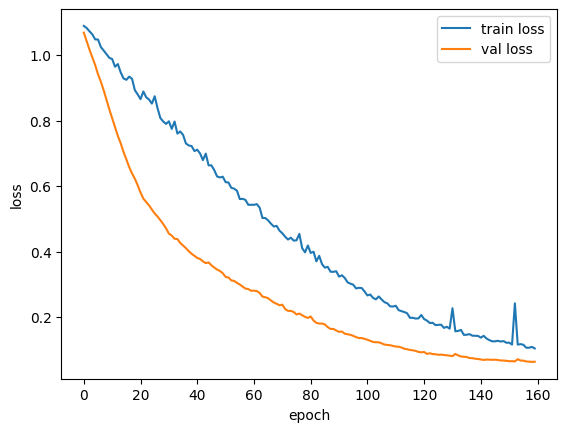

In [112]:
# accuracy

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f'test accuracy: {test_accuracy}')
print(f'test precision: {test_precision}')
print(f'test recall: {test_recall}')
print(f'test f1-score: {test_f1}')

# график для
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [113]:
# Функция для запуска предсказания по report
def eval_net(reports, model, tokenizer):
  results = []
  for report in reports:
    model.to('cuda')
    tokenized_input = tokenizer(report, return_tensors='pt')
    input_ids = tokenized_input['input_ids'].to('cuda')
    attention_mask = tokenized_input['attention_mask'].to('cuda')

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits

    quest_label = torch.argmax(logits, dim=1).item()
    pred_class = le.classes_[quest_label]

    results.append(pred_class)
  return results

# Пример

print(eval_net(["Спасибо"], model, tokenizer))


['благодарность']


In [114]:
# сохранение модели, потом импортируем в районе серверной части
output_dir="/model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/model/tokenizer_config.json',
 '/model/special_tokens_map.json',
 '/model/vocab.txt',
 '/model/added_tokens.json',
 '/model/tokenizer.json')

In [118]:
# восстановление модели
imported_model = AutoModelForSequenceClassification.from_pretrained(output_dir, num_labels=3)
imported_tokenizer = AutoTokenizer.from_pretrained(output_dir)

# запуск модели
print(eval_net(["Спасибо", "Плохо"], imported_model, imported_tokenizer))

['благодарность', 'претензия']
